# Setting up Colab

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 9.2MB/s 


In [0]:
# importing file from gdrive
link = 'https://drive.google.com/open?id=1womfzt0XeHfJZIBAUOOLL1-uY_YiOtoI' # Paste the shareable link here

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv') # file will be stored as train.csv in the colab directory

1womfzt0XeHfJZIBAUOOLL1-uY_YiOtoI


In [0]:
# loading libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
#reading data
churn_data = pd.read_csv('train.csv')

In [0]:
churn_data.shape

(100000, 100)

In [0]:
churn_data.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,...,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.000000,...,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,O,15.0,S,S,1.0,M,4.0,3.0,C,A,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.000000,...,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,U,CHICAGO AREA,N,N,NaN,7.0,6.0,WC,1.0,1.0,NaN,1.0,S,S,1.0,M,5.0,1.0,C,A,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.000000,...,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,S,GREAT LAKES AREA,N,N,29.98999,2.0,1.0,NaN,0.0,0.0,O,7.0,S,M,2.0,M,5.0,2.0,C,A,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.666667,0.0,1.333333,0.0,3.666667,0.0,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,0.0,3.666667,...,1479,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,T,CHICAGO AREA,N,N,29.98999,1.0,1.0,NaN,0.0,0.0,NaN,6.0,M,M,4.0,M,6.0,1.0,C,D,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.0,94.666667,0.0,137.000000,0.0,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,0.0,90.333333,...,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,U,NEW ENGLAND AREA,Y,N,149.98999,6.0,4.0,WCMB,0.0,0.0,R,5.0,M,S,1.0,M,6.0,1.0,C,O,0.0,I,U,U,U,U,U,Y,434.0,1000005


In [0]:
# data types
churn_data.dtypes.value_counts()

float64    69
object     21
int64      10
dtype: int64

# EDA and Feature Engineering

Why people churn out in telecom industry? 
*   Is it because of poor service quality? 
*   Is there any behavioral or demographic pattern?
*   Are there any logistics issues?

Let's explore all the variables and try to answer these questions.










In [0]:
# Which variables are correlated with Churn?
abs(churn_data.corr()['churn']).sort_values(ascending = False)[:10]

churn            1.000000
eqpdays          0.112691
hnd_price        0.103184
totmrc_Mean      0.068558
mou_Mean         0.057027
mou_cvce_Mean    0.052042
complete_Mean    0.051740
comp_vce_Mean    0.051574
avg3mou          0.049546
mou_opkv_Mean    0.048896
Name: churn, dtype: float64

No strong correlation with any of the variables

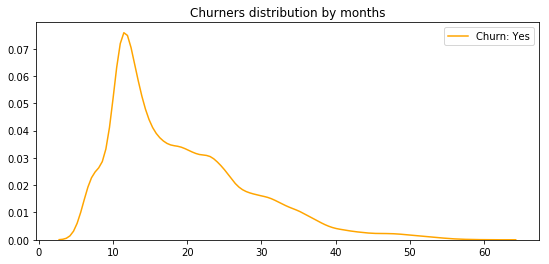

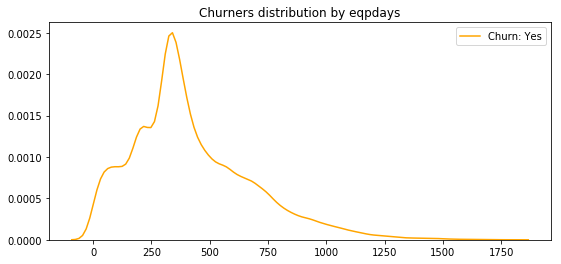

In [0]:
# When do people actually churn?

import seaborn as sns; 
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("Churners distribution by {}".format(feature))
    #ax0 = sns.kdeplot(churn_data[churn_data['churn'] == 0][feature].dropna(), color= 'navy', label= 'Churn: No', xlabel = 'xx')
    ax1 = sns.kdeplot(churn_data[churn_data['churn'] == 1][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('months')
kdeplot('eqpdays')

Most of the churners seem to be stacked around 12 months mark of service use and equipment age. This strongly indicates that churners are changing both network and phone after a year, maybe they are getting better upgrades in other networks! Let's explore more!!


In [0]:
# let's convert eqp usage duration from days to months
churn_data['eqpdays_to_month'] = (churn_data['eqpdays'] / 30).round(0)
churn_data['eqpdays_to_month'].head()

0    12.0
1     8.0
2    50.0
3    60.0
4    14.0
Name: eqpdays_to_month, dtype: float64

In [0]:
# As we saw earlier, equipment age and month in service are correlated
churn_data[churn_data['churn'] == 1]['eqpdays_to_month'].corr(churn_data[churn_data['churn'] == 1]['months']).round(1)

0.6

Text(0.5, 1.0, 'Monthly usage decreases as the equipment grows older')

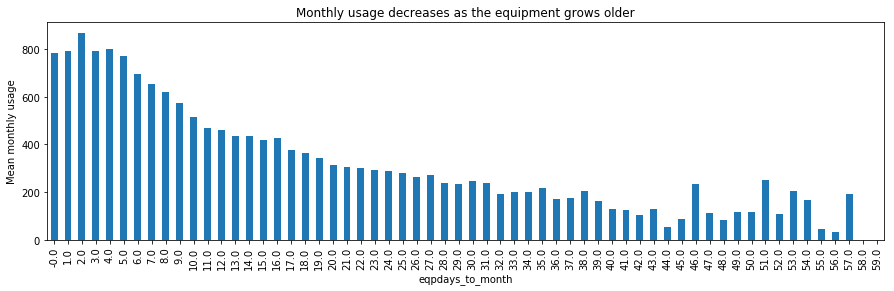

In [0]:
# Churners - People tend to get bored by their phones overtime and start using less, equipment age seems to be a strong indicator for a new phone contract
churn_data[churn_data['churn']==1].groupby('eqpdays_to_month')['mou_Mean'].mean().plot(kind='bar', figsize=(15, 4))
plt.ylabel('Mean monthly usage')
plt.title('Monthly usage decreases as the equipment grows older')

Text(0.5, 1.0, 'Monthly usage decreases as the equipment grows older')

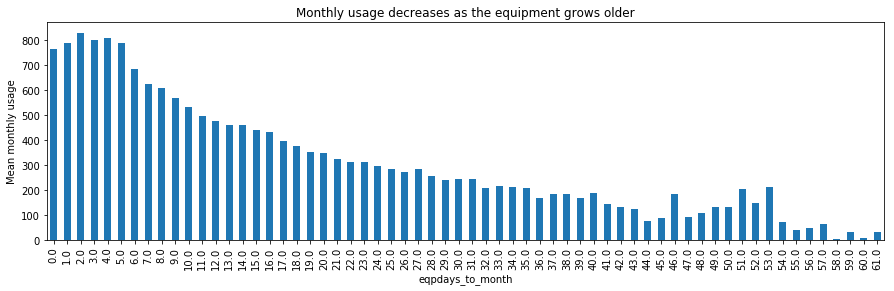

In [0]:
# People tend to get bored by their phones overtime and start using less, equipment age seems to be a strong indicator for a new phone contract
churn_data.groupby('eqpdays_to_month')['mou_Mean'].mean().plot(kind='bar', figsize=(15, 4))
plt.ylabel('Mean monthly usage')
plt.title('Monthly usage decreases as the equipment grows older')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 1.0, 'High churn for cheaper phones')

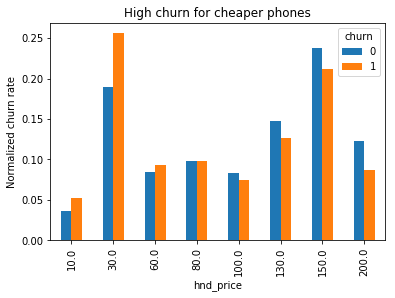

In [0]:
# checking interaction between handset price and user churn
churn_data_subset = churn_data[churn_data.groupby('hnd_price')['hnd_price'].transform('size') > 1000]
churn_data_subset['hnd_price'] = churn_data_subset['hnd_price'].round(0)
pop_hnd_crosstab = pd.crosstab(churn_data_subset["hnd_price"], churn_data_subset["churn"])
total_churn = pop_hnd_crosstab.apply(sum)
pop_hnd_crosstab /= total_churn
pop_hnd_crosstab.plot(kind='bar')
plt.ylabel('Normalized churn rate')
plt.title('High churn for cheaper phones')

Higher the price of handset, lower the churn rate! People extract the meaximum juice out of the costlier phones and hence the dip in churn rate!!

Text(0.5, 1.0, 'Cheaper phones have higher churn rate')

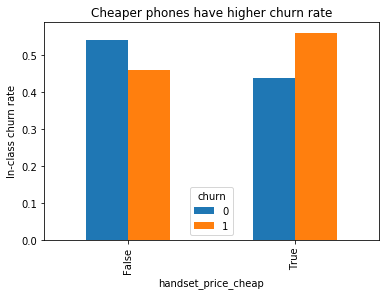

In [0]:
# let's segregate the cheap phones and costlier ones
churn_data['handset_price_cheap'] = (churn_data['hnd_price'] < 60)

# users with cheap handsets churn out more - maybe they just grab best of offers and move on
churn_data.groupby('handset_price_cheap')['churn'].value_counts(normalize=True).unstack('churn').plot(kind = 'bar')
plt.ylabel('In-class churn rate')
plt.title('Cheaper phones have higher churn rate')

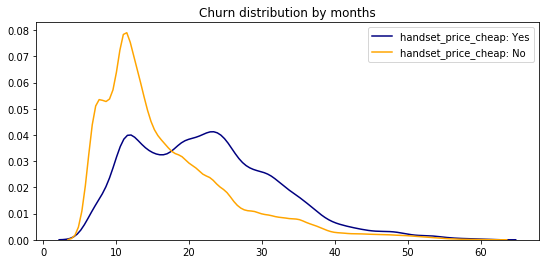

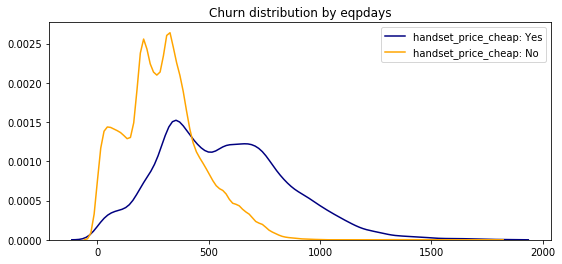

In [0]:
# let's check how the churn point is for different handset price groups 
def kdeplot2(feature):
    plt.figure(figsize=(9, 4))
    plt.title("Churn distribution by {}".format(feature))
    ax0 = sns.kdeplot(churn_data[churn_data['handset_price_cheap'] == True][feature].dropna(), color= 'navy', label= 'handset_price_cheap: Yes')
    ax1 = sns.kdeplot(churn_data[churn_data['handset_price_cheap'] == False][feature].dropna(), color= 'orange', label= 'handset_price_cheap: No')
kdeplot2('months')
kdeplot2('eqpdays')

People tend to use costlier phone contracts for longer duration! 

Let's check churn rate by phone compatibility

Text(0.5, 1.0, 'Non dualband phones have higher churn rate')

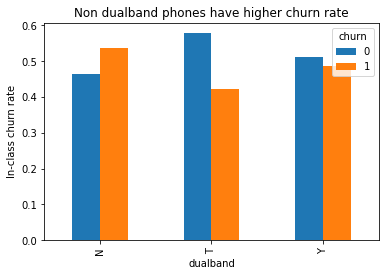

In [0]:
# Non dual abnd phones or low end phones see more churn rate
churn_data[churn_data['dualband'] != 'U'].groupby('dualband')['churn'].value_counts(normalize=True).unstack('churn').plot(kind = 'bar')
plt.ylabel('In-class churn rate')
plt.title('Non dualband phones have higher churn rate')

Text(0.5, 1.0, 'WC phones have higher churn rate')

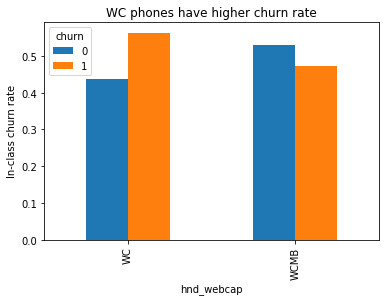

In [0]:
churn_data[churn_data['hnd_webcap'] != 'UNKW'].groupby('hnd_webcap')['churn'].value_counts(normalize=True).unstack('churn').plot(kind = 'bar')
plt.ylabel('In-class churn rate')
plt.title('WC phones have higher churn rate')

Text(0.5, 1.0, 'Refurbished phones are less durable')

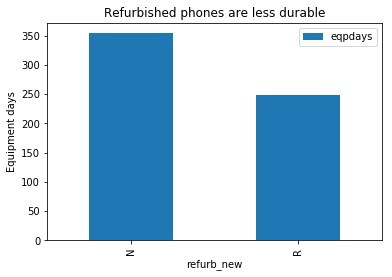

In [0]:
# Equipment age of refurbished phones
churn_data.groupby(['refurb_new'])[['eqpdays']].median().plot(kind = 'bar')
plt.ylabel('Equipment days')
plt.title('Refurbished phones are less durable')

Text(0.5, 1.0, 'Refurbished phones have higher churn rate')

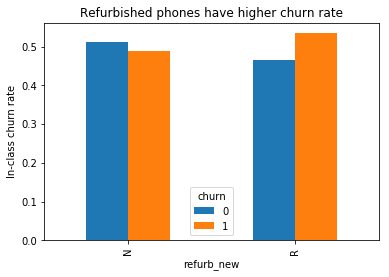

In [0]:
# Refurbished phone users tend to churn out more. We saw earlier that refurbished phone has low durability, this opens the door to explore more network options
churn_data.groupby('refurb_new')['churn'].value_counts(normalize=True).unstack('churn').plot(kind = 'bar')
plt.ylabel('In-class churn rate')
plt.title('Refurbished phones have higher churn rate')

Upgrading handset seems to be a major reason for churn so far.

Let's explore user behavior and demographic details now.

In [0]:
churn_data['lor_binned'] = pd.cut(churn_data['lor'], 4)
churn_data['lor_binned'] = churn_data['lor_binned'].astype(str)

churn_data['lor_binned']=churn_data['lor_binned'].replace('(-0.015, 3.75]','0-3.7')
churn_data['lor_binned']=churn_data['lor_binned'].replace('(3.75, 7.5]','3.7-7.5')
churn_data['lor_binned']=churn_data['lor_binned'].replace('(11.25, 15.0]','11.2-15')
churn_data['lor_binned']=churn_data['lor_binned'].replace('(7.5, 11.25]','7.5-11.2')

Text(0.5, 1.0, 'Length of residence is inversely proportional to churn rate')

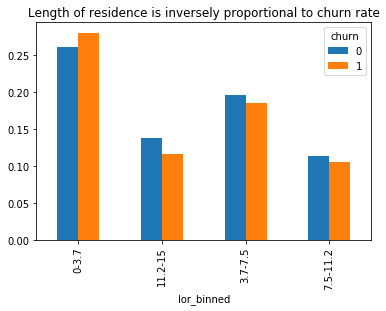

In [0]:
lor_crosstab = pd.crosstab(churn_data["lor_binned"].sort_values(), churn_data["churn"])
total_churn = lor_crosstab.apply(sum)
lor_crosstab /= total_churn
lor_crosstab.drop(['nan'], inplace = True)
lor_crosstab.plot(kind='bar')

plt.title('Length of residence is inversely proportional to churn rate')

In [0]:
churn_data['models'].value_counts()

1.0     63273
2.0     25041
3.0      7822
4.0      2472
5.0       852
6.0       330
7.0       117
8.0        50
9.0        25
10.0       11
11.0        3
15.0        1
16.0        1
14.0        1
Name: models, dtype: int64

In [0]:
churn_data['models_more_than_one'] = (churn_data['models'] > 1)
churn_data['models_more_than_one'].value_counts()

False    63274
True     36726
Name: models_more_than_one, dtype: int64

Text(0.5, 1.0, 'Customers with more than 1 model seems loyal with less churn rate')

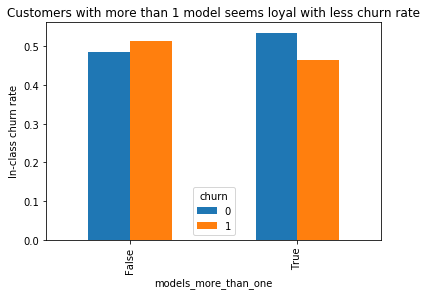

In [0]:
# Customers with more than 1 model shows loyalty of customer and hence less churn
churn_data.groupby('models_more_than_one')['churn'].value_counts(normalize=True).unstack('churn').plot(kind = 'bar')
plt.ylabel('In-class churn rate')
plt.title('Customers with more than 1 model seems loyal with less churn rate')

In [0]:
churn_data['uniqsubs'].value_counts()

1      61966
2      27556
3       6579
4       2556
5        835
6        315
7        111
8         40
9         20
10         9
11         5
12         4
13         2
18         1
196        1
Name: uniqsubs, dtype: int64

In [0]:
#bucketing unique subscribers
churn_data['uniqsubs_more_than_one'] = (churn_data['uniqsubs'] > 1)

Text(0, 0.5, 'In-class churn rate')

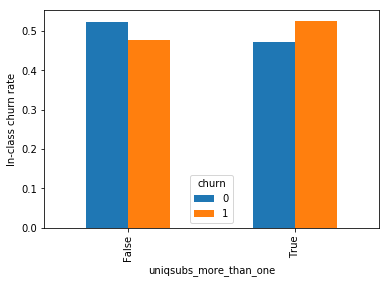

In [0]:
# more than 1 unique subscribers tend to churn more, not good for business losing multiple customers at a time
churn_data.groupby('uniqsubs_more_than_one')['churn'].value_counts(normalize=True).unstack('churn').plot(kind = 'bar')
plt.ylabel('In-class churn rate')

In [0]:
# mean monthly usage pattern
churn_data.groupby('churn')['mou_Mean'].median()

churn
0    380.50
1    329.75
Name: mou_Mean, dtype: float64

In [0]:
churn_data[churn_data['mou_Mean']>1500].shape

(5456, 105)

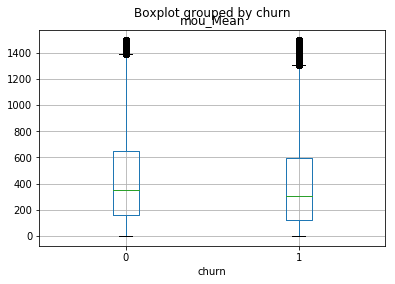

In [0]:
churn_data[churn_data['mou_Mean']<1500].boxplot(column = ['mou_Mean'], by ='churn')

Text(0.5, 1.0, 'Churners have lower monthly usage')

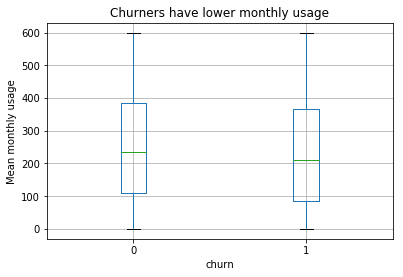

In [0]:
# Churners mean monthly usage is less in comparison to non churners
churn_data[churn_data['mou_Mean']<600].boxplot(column = ['mou_Mean'], by ='churn')

plt.suptitle('')
plt.ylabel('Mean monthly usage')
plt.title('Churners have lower monthly usage')

Text(0.5, 1.0, 'Churners have lower monthly usage')

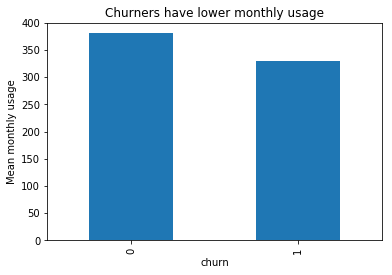

In [0]:
(churn_data.groupby('churn')['mou_Mean'].median()).plot(kind = 'bar')

plt.ylabel('Mean monthly usage')
plt.title('Churners have lower monthly usage')

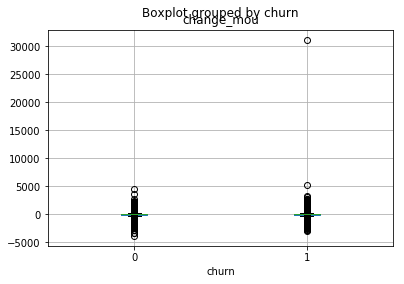

In [0]:
churn_data.boxplot(column = 'change_mou', by = 'churn')

In [0]:
(churn_data[churn_data['change_mou']>500].shape[0]), (churn_data[churn_data['change_mou']<-500].shape[0])

(2546, 3155)

In [0]:
churn_data[(churn_data['change_mou']<500) & (churn_data['change_mou']>-500)].groupby('churn')['change_mou'].mean()

churn
0    -1.770387
1   -16.995938
Name: change_mou, dtype: float64

Text(0.5, 1.0, 'Monthly usage dips a lot for churners')

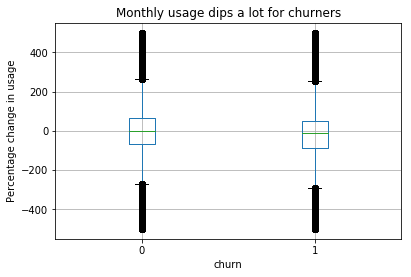

In [0]:
# Percentage change in monthly minutes of use vs previous three month average - negative so less using
churn_data[(churn_data['change_mou']<500) & (churn_data['change_mou']>-500)].boxplot(column = 'change_mou', by = 'churn')

plt.suptitle('')
plt.ylabel('Percentage change in usage')
plt.title('Monthly usage dips a lot for churners')

Text(0.5, 1.0, 'Monthly usage dips a lot for churners')

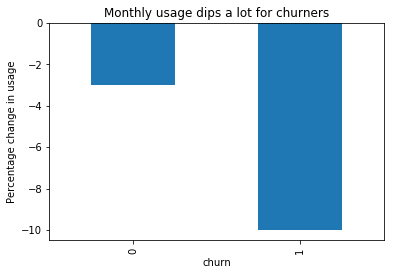

In [0]:
# Dip in Churners usage pattern
(churn_data.groupby('churn')['change_mou'].median()).plot(kind = 'bar')

plt.ylabel('Percentage change in usage')
plt.title('Monthly usage dips a lot for churners')

Text(0, 0.5, 'Mean roaming usage')

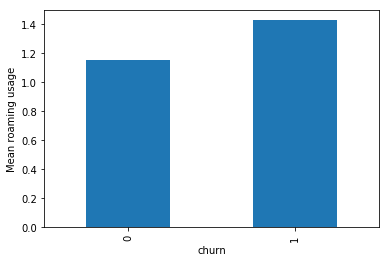

In [0]:
(churn_data.groupby('churn')['roam_Mean'].mean()).plot(kind = 'bar')

plt.ylabel('Mean roaming usage')

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


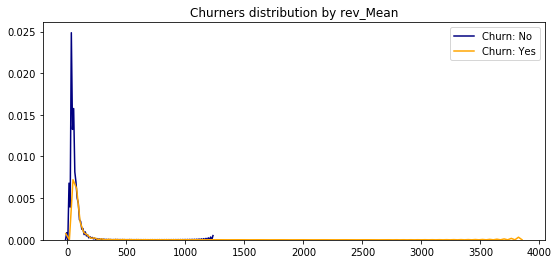

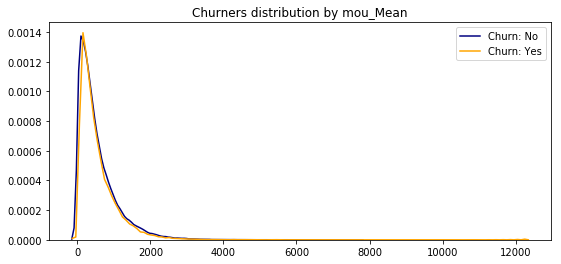

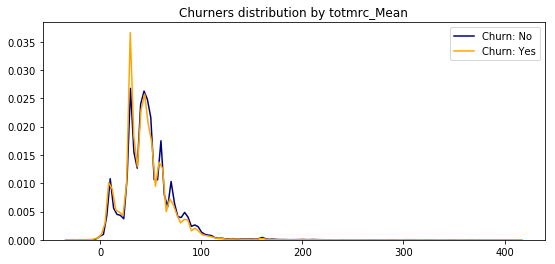

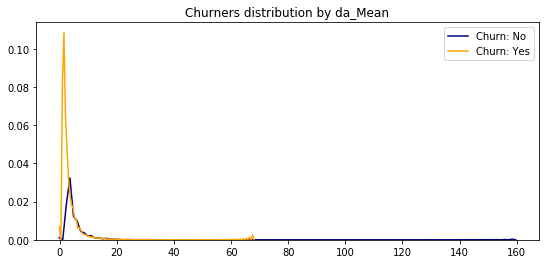

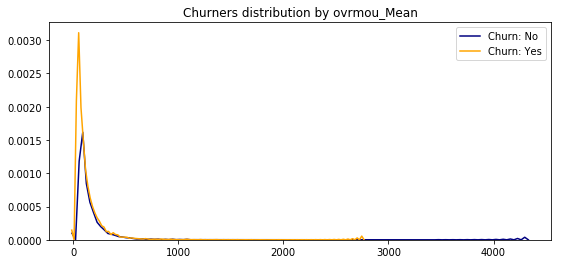

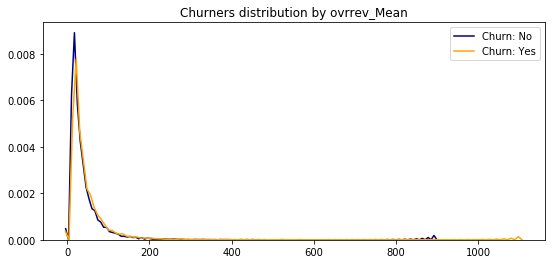

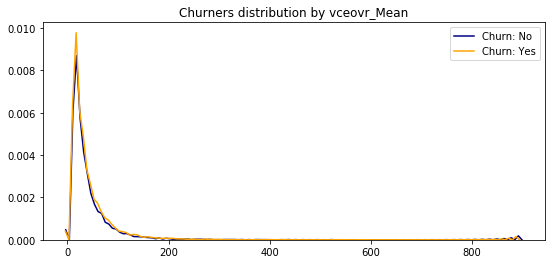

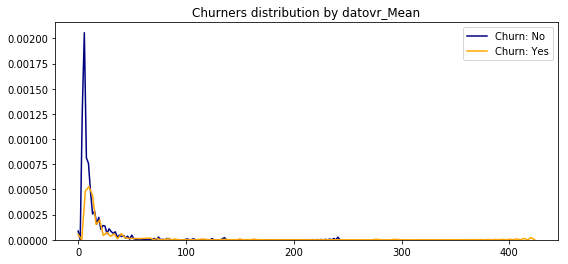

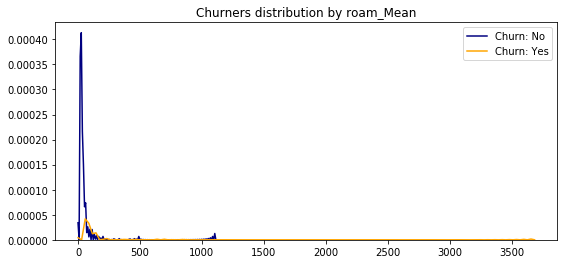

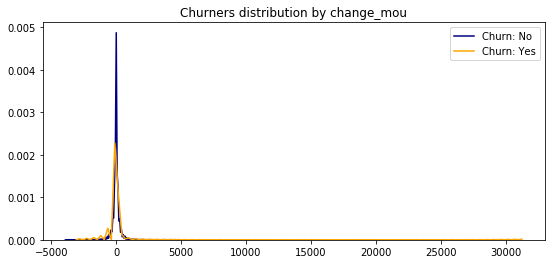

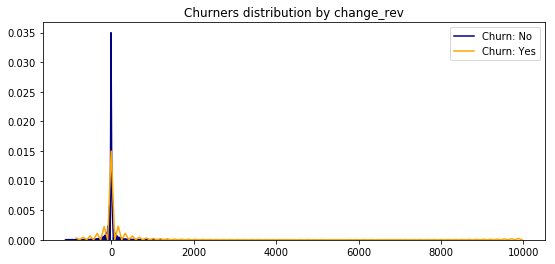

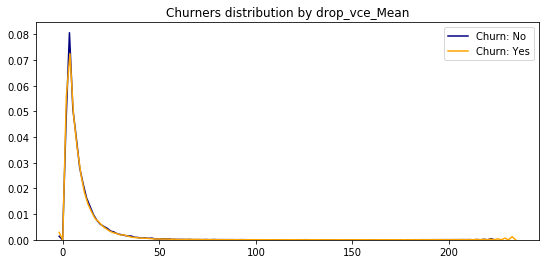

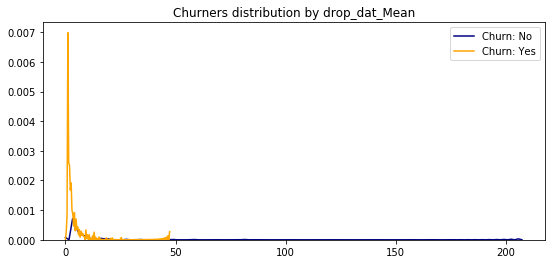

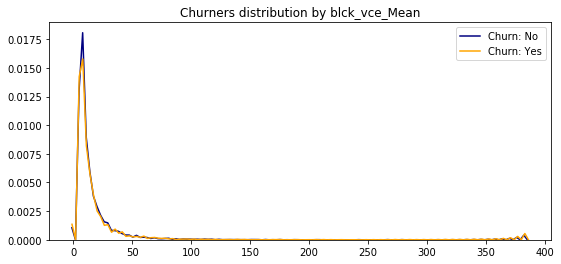

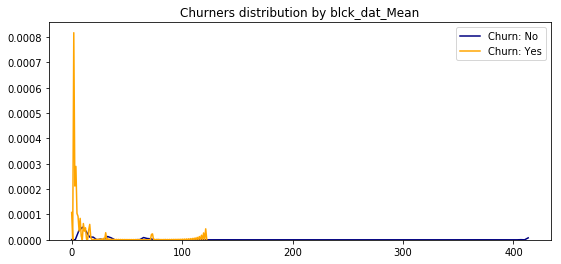

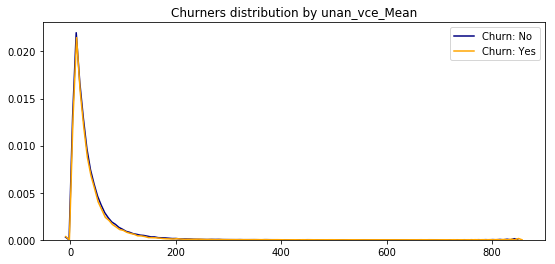

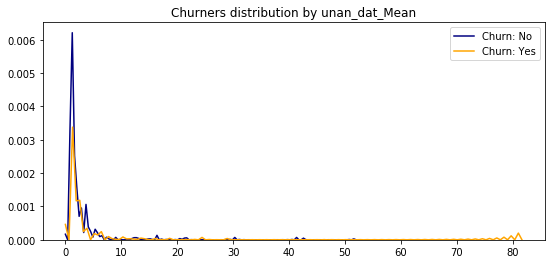

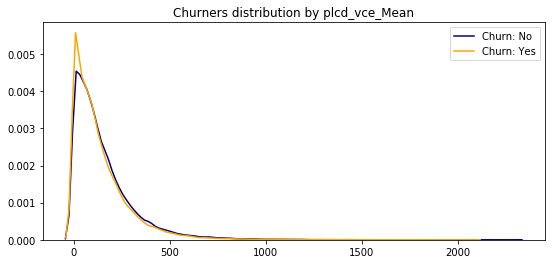

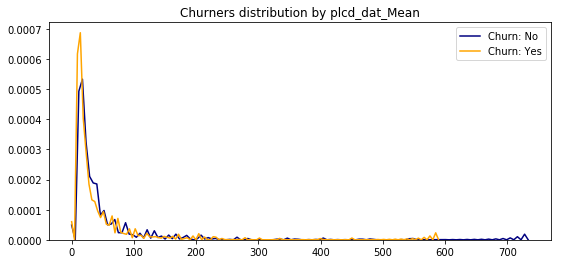

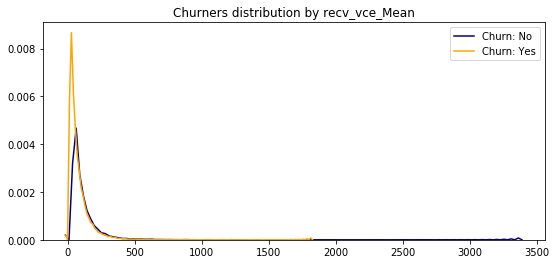

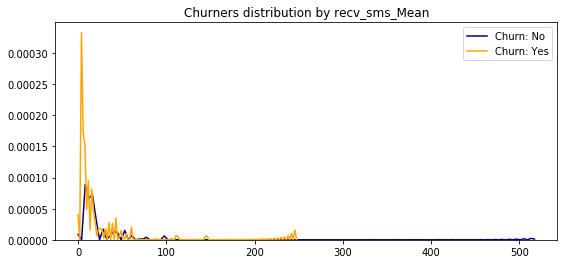

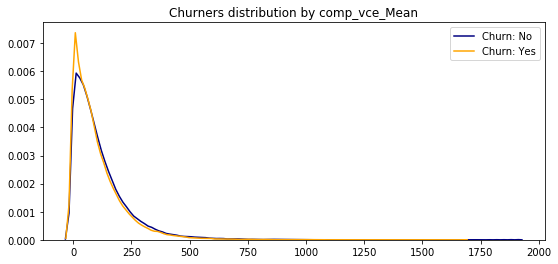

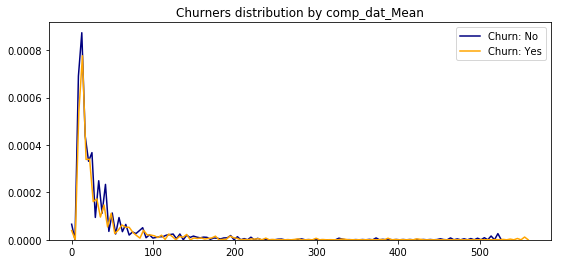

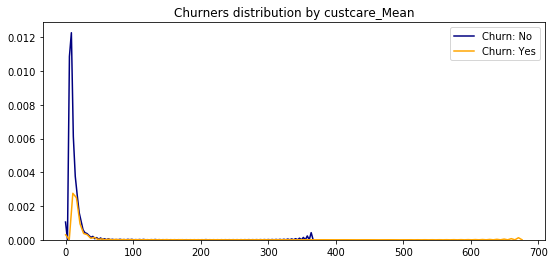

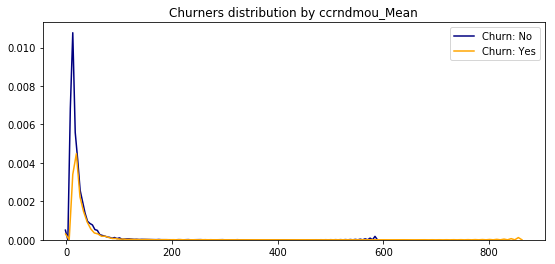

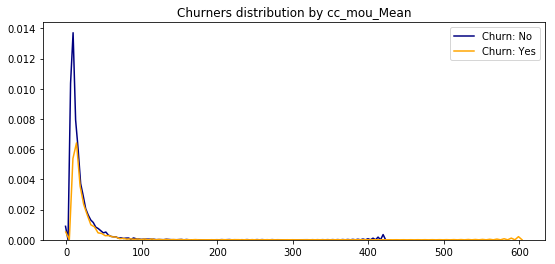

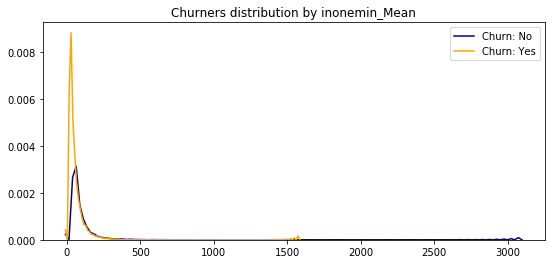

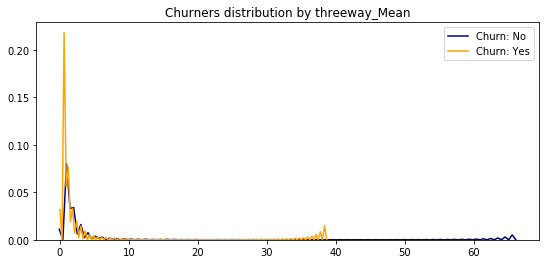

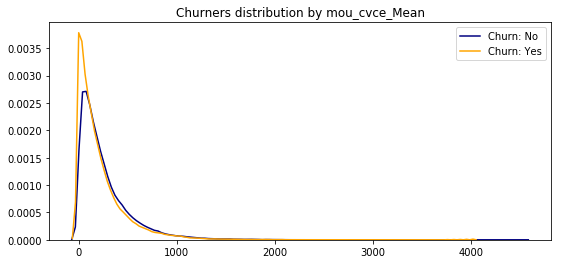

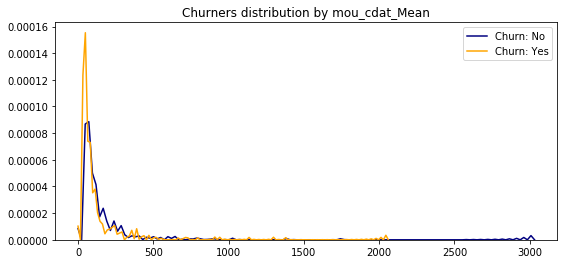

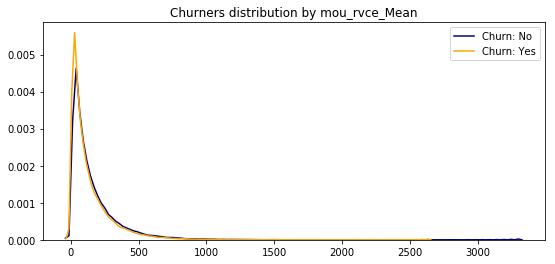

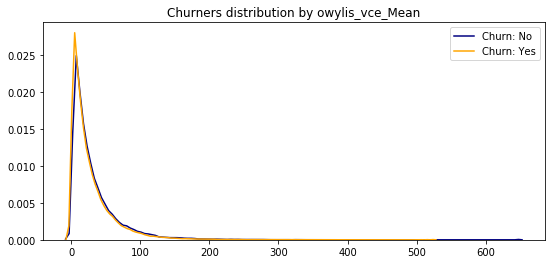

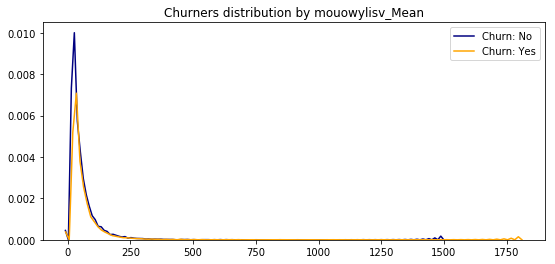

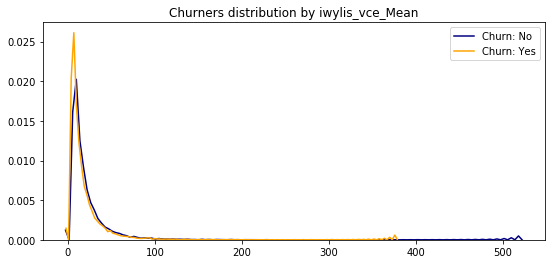

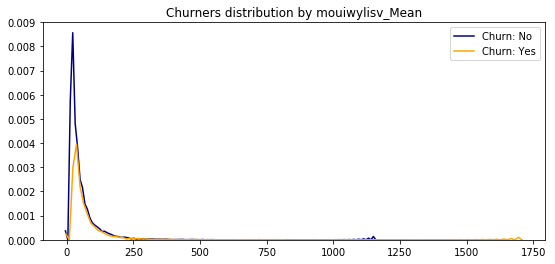

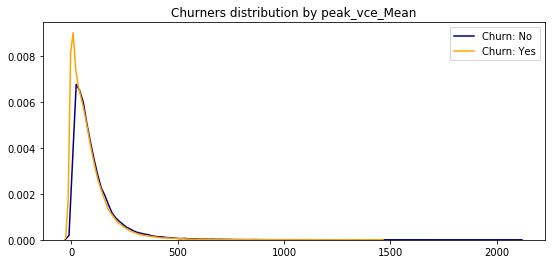

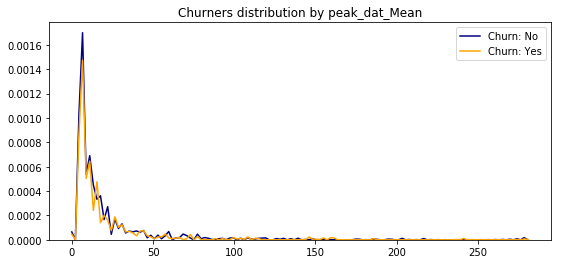

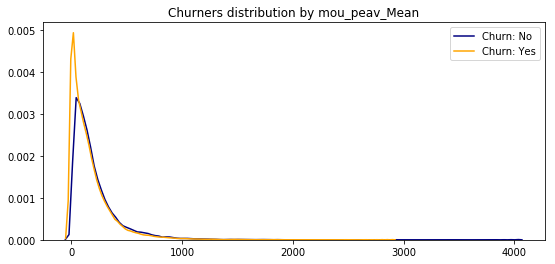

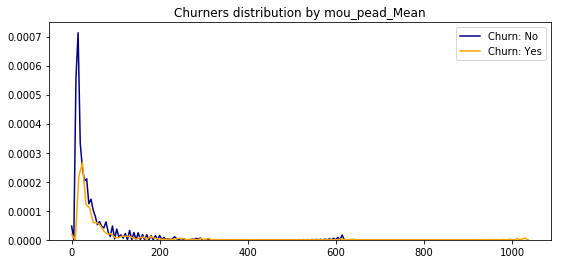

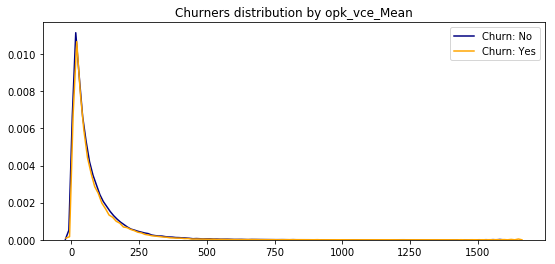

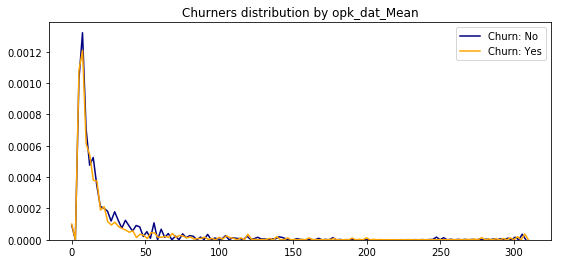

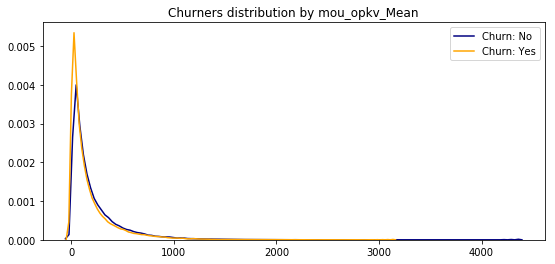

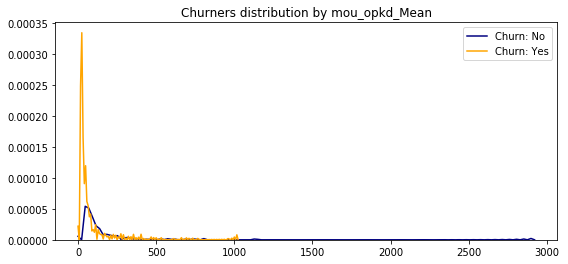

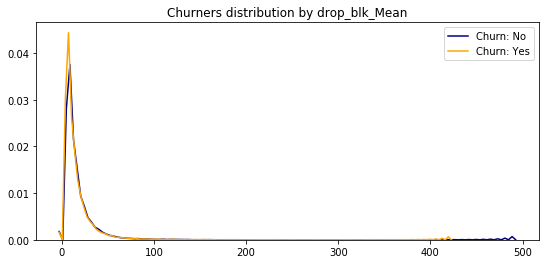

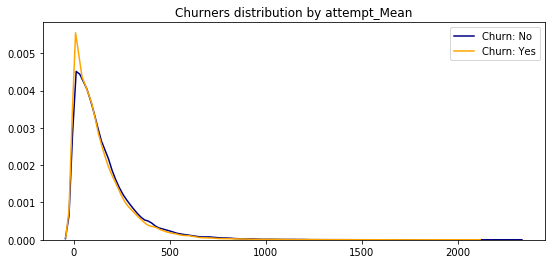

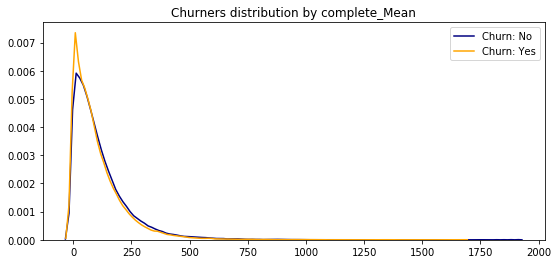

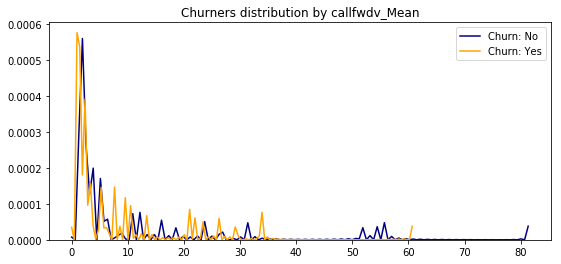

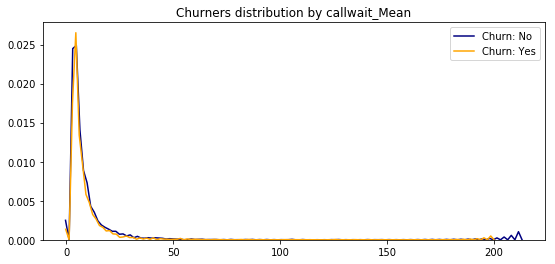

In [0]:
# Let's check other continuous variables -- not much intuitive

def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("Churners distribution by {}".format(feature))
    ax0 = sns.kdeplot(churn_data[churn_data['churn'] == 0][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(churn_data[churn_data['churn'] == 1][feature].dropna(), color= 'orange', label= 'Churn: Yes')


for i in churn_data.iloc[:,0:48].columns:
  kdeplot(i)

# Null Value Treatment

In [0]:
churn_data.isnull().sum().sort_values(ascending = False).head(20)

numbcars            49366
dwllsize            38308
HHstatin            37923
ownrent             33706
dwlltype            31909
lor                 30190
income              25436
adults              23019
infobase            22079
hnd_webcap          10189
prizm_social_one     7388
avg6qty              2839
avg6mou              2839
avg6rev              2839
creditcd             1732
truck                1732
rv                   1732
kid0_2               1732
marital              1732
kid3_5               1732
dtype: int64

In [0]:
churn_data.fillna(0, inplace = True)

In [0]:
churn_data.isnull().any().sum()

0

In [0]:
churn_data.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,...,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID,eqpdays_to_month,handset_price_cheap,lor_binned,models_more_than_one,uniqsubs_more_than_one
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.000000,...,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,O,15.0,S,S,1.0,M,4.0,3.0,C,A,0.0,N,U,U,U,U,U,Y,361.0,1000001,12.0,False,11.2-15,True,True
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.000000,...,158,40,477.0,275.0,48.0,U,CHICAGO AREA,N,N,0.00000,7.0,6.0,WC,1.0,1.0,0,1.0,S,S,1.0,M,5.0,1.0,C,A,0.0,Z,U,U,U,U,U,Y,240.0,1000002,8.0,False,0-3.7,True,False
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.000000,...,7,17,11.0,6.0,17.0,S,GREAT LAKES AREA,N,N,29.98999,2.0,1.0,0,0.0,0.0,O,7.0,S,M,2.0,M,5.0,2.0,C,A,0.0,N,U,Y,U,U,U,Y,1504.0,1000003,50.0,True,3.7-7.5,False,False
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.666667,0.0,1.333333,0.0,3.666667,0.0,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,0.0,3.666667,...,3,38,50.0,25.0,40.0,T,CHICAGO AREA,N,N,29.98999,1.0,1.0,0,0.0,0.0,0,6.0,M,M,4.0,M,6.0,1.0,C,D,0.0,U,Y,U,U,U,U,Y,1812.0,1000004,60.0,True,3.7-7.5,False,False
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.0,94.666667,0.0,137.000000,0.0,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,0.0,90.333333,...,191,55,586.0,196.0,80.0,U,NEW ENGLAND AREA,Y,N,149.98999,6.0,4.0,WCMB,0.0,0.0,R,5.0,M,S,1.0,M,6.0,1.0,C,O,0.0,I,U,U,U,U,U,Y,434.0,1000005,14.0,False,3.7-7.5,True,False


# Modeling

In [0]:
churn_data.drop(columns = ['Customer_ID','eqpdays_to_month'], inplace = True)

In [0]:
# creating subset data based on EDA
churn_data_subset = new = churn_data[['uniqsubs_more_than_one','change_mou','roam_Mean','totrev','avgrev','models_more_than_one','months','eqpdays','mou_Mean','hnd_price','handset_price_cheap','dualband','hnd_webcap','refurb_new','lor_binned','churn']]

In [0]:
churn_data = pd.get_dummies(churn_data)
churn_data.shape

(100000, 257)

**Logitic Regression with all variables**

In [0]:
churn_data_logistics = churn_data.copy(deep =True)

In [0]:
# Feature names
features = list(churn_data_logistics.columns)

# Scale each feature to 0-1

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))

scaler.fit(churn_data_logistics)
churn_data_logistics = pd.DataFrame(scaler.transform(churn_data_logistics))

churn_data_logistics.columns = features
churn_data_logistics.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,...,ethnic_B,ethnic_C,ethnic_D,ethnic_F,ethnic_G,ethnic_H,ethnic_I,ethnic_J,ethnic_M,ethnic_N,ethnic_O,ethnic_P,ethnic_R,ethnic_S,ethnic_U,ethnic_X,ethnic_Z,kid0_2_0,kid0_2_U,kid0_2_Y,kid3_5_0,kid3_5_U,kid3_5_Y,kid6_10_0,kid6_10_U,kid6_10_Y,kid11_15_0,kid11_15_U,kid11_15_Y,kid16_17_0,kid16_17_U,kid16_17_Y,creditcd_0,creditcd_N,creditcd_Y,lor_binned_0-3.7,lor_binned_11.2-15,lor_binned_3.7-7.5,lor_binned_7.5-11.2,lor_binned_nan
0,0.007836,0.017961,0.113102,0.001553,0.000000,0.000000,0.000000,0.0,0.0,0.105936,0.098338,0.002865,0.0,0.001730,0.0,0.007463,0.0,0.022863,0.0,0.012564,0.0,0.023755,0.0,0.000000,0.000000,0.000000,0.005832,0.000000,0.020078,0.0,0.029562,0.000000,0.000000,0.000000,0.000000,0.027742,0.0,0.033023,0.0,0.014604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.016538,0.039548,0.147263,0.001553,0.005265,0.008255,0.010155,0.0,0.0,0.125583,0.104660,0.035817,0.0,0.002595,0.0,0.072270,0.0,0.115043,0.0,0.020479,0.0,0.102059,0.0,0.002468,0.007353,0.009061,0.017171,0.005051,0.041953,0.0,0.016816,0.071909,0.013434,0.012195,0.002170,0.040019,0.0,0.018761,0.0,0.095538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.006016,0.000840,0.100491,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.110296,0.100054,0.001433,0.0,0.000000,0.0,0.003142,0.0,0.003932,0.0,0.000099,0.0,0.003167,0.0,0.000000,0.000000,0.000000,0.000108,0.000000,0.001202,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.002392,0.0,0.001293,0.0,0.000609,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.011474,0.000614,0.148579,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.110374,0.100054,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.001602,0.0,0.000396,0.0,0.001936,0.0,0.000000,0.000000,0.000000,0.000432,0.000000,0.001863,0.0,0.000126,0.000517,0.000142,0.000000,0.000000,0.000638,0.0,0.000842,0.0,0.002231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.015950,0.046736,0.226354,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.111514,0.100054,0.041547,0.0,0.001730,0.0,0.090731,0.0,0.097131,0.0,0.028097,0.0,0.072321,0.0,0.012833,0.017415,0.018371,0.021382,0.000000,0.063182,0.0,0.032346,0.022763,0.006000,0.001284,0.000215,0.046556,0.0,0.043203,0.0,0.054970,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [0]:
from sklearn.model_selection import train_test_split
train_logistics, test_logistics = train_test_split(churn_data_logistics, test_size = 0.25, random_state = 42)

In [0]:
y_logistics = train_logistics['churn'].copy()
train_logistics.drop(columns = 'churn', inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [0]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0, solver='lbfgs').fit(train_logistics, y_logistics)
pred_log = model.predict_proba(test_logistics.loc[:,test_logistics.columns != 'churn'])[:,1]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [0]:
# Area under the curve
from sklearn.metrics import roc_curve, roc_auc_score
roc_auc_score(test_logistics.loc[:,test_logistics.columns == 'churn'], pred_log).round(4)

0.6192

**Random Forest with subset variables**

In [0]:
churn_data_subset.shape

(100000, 16)

In [0]:
churn_data_subset = pd.get_dummies(churn_data_subset)

from sklearn.model_selection import train_test_split
train_subset, test_subset = train_test_split(churn_data_subset, test_size = 0.25, random_state = 42)

y_subset = train_subset['churn'].copy()
train_subset.drop(columns = 'churn', inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [0]:
from sklearn.ensemble import RandomForestClassifier

# Initialize
random_forest = RandomForestClassifier(n_estimators = 1000, random_state = 50, verbose = 1, n_jobs = -1) #n_jobs = -1 meaning utilize all system resources

# Fit the model
rf_model_subset = random_forest.fit(train_subset, y_subset)

# Make predictions on the test data
pred_rf_subset = random_forest.predict_proba(test_subset.loc[:,test_subset.columns != 'churn'])[:, 1]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    5.8s finished


In [0]:
# Area under the curve
from sklearn.metrics import roc_curve, roc_auc_score
roc_auc_score(test_subset.loc[:,test_subset.columns == 'churn'], pred_rf_subset).round(4)

0.6457

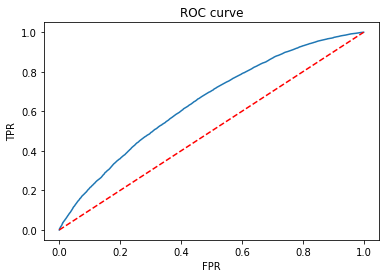

In [0]:
# ROC plot
fpr_rf_sub, tpr_rf_sub, _ = roc_curve(test_subset.loc[:,test_subset.columns == 'churn'], pred_rf_subset)

plt.clf()
plt.plot(fpr_rf_sub, tpr_rf_sub)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

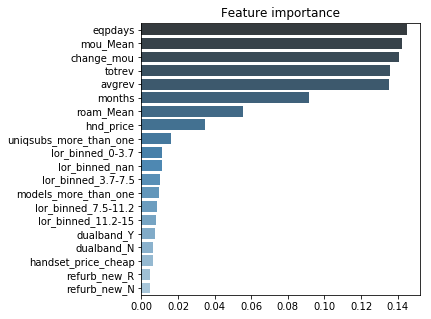

In [0]:
# Feature importannce
ft_imp = pd.Series(data=rf_model_subset.feature_importances_, index=train_subset.columns).sort_values(ascending=False)[:20]
plt.figure(figsize=(5,5))
plt.title("Feature importance")
ax = sns.barplot(y=ft_imp.index, x=ft_imp.values, palette="Blues_d", orient='h')

**Random Forest with all the variables**

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(churn_data, test_size = 0.25, random_state = 42)

In [0]:
y = train['churn'].copy()
y.head()

98980    0
69824    0
9928     0
75599    0
95621    1
Name: churn, dtype: int64

In [0]:
train.drop(columns = 'churn', inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


**Random Forest**

In [0]:
from sklearn.ensemble import RandomForestClassifier

# Initialize
random_forest = RandomForestClassifier(n_estimators = 1000, random_state = 50, verbose = 1, n_jobs = -1) #n_jobs = -1 meaning utilize all system resources

In [0]:
# Fit the model
rf_model = random_forest.fit(train, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.6min finished


In [0]:
# Make predictions on the test data
pred_rf = random_forest.predict_proba(test.loc[:,test.columns != 'churn'])[:, 1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    6.0s finished


In [0]:
# Area under the curve
from sklearn.metrics import roc_curve, roc_auc_score
roc_auc_score(test.loc[:,test.columns == 'churn'], pred_rf).round(4)

0.6829

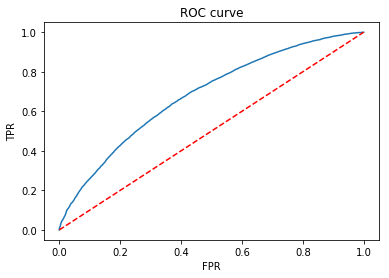

In [0]:
# ROC plot
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(test.loc[:,test.columns == 'churn'], pred_rf)

plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [0]:
# # ft_imp_copy = ft_imp.copy()
# #ft_imp_copy.drop(['eqpdays_to_month'], inplace = True)
# plt.figure(figsize=(5,5))
# plt.title("Feature importance")
# ax = sns.barplot(y=ft_imp_copy.index, x=ft_imp_copy.values, palette="Blues_d", orient='h')


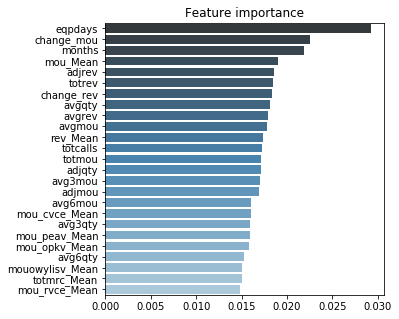

In [0]:
# Feature importannce
ft_imp = pd.Series(data=rf_model.feature_importances_, index=train.columns).sort_values(ascending=False)[:25]
plt.figure(figsize=(5,5))
plt.title("Feature importance")
ax = sns.barplot(y=ft_imp.index, x=ft_imp.values, palette="Blues_d", orient='h')

**XGBoost**

In [0]:
# splitting data in train and validation set
xgb_train, xgb_val, xgb_y_train, xgb_y_val = train_test_split(train, y, test_size = 0.2, random_state = 42)

In [0]:
# initializing parameters
import xgboost as xgb

params = {
   
    'max_depth': 7, # to control over-fitting, optimal value range: 3-10
    'gamma' :0, # the minimum loss reduction required to make a split, XGB will build the tree first then prune in case of 0 gamma
    'eta':.05, # shrinkage factor, optimal value range: 0.01-0.2
    'subsample': 0.7, # fraction of observations to be randomly samples for each tree, optimal value range: 0.5-1
    'colsample_bytree': 0.7, # fraction of columns to be randomly samples for each tree, optimal value range: 0.5-1
    'objective':'binary:logistic', # loss function to be minimized
    'eval_metric':'auc', # metric to be used for validation data
    'silent': 0 # running messages will be printed
}

In [0]:
# setting up model
def XGBmodel(X_train,X_test,y_train,y_test,params):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model=xgb.train(params=params,
                    dtrain=matrix_train,
                    num_boost_round=1000, # number of boosting rounds or trees to build
                    early_stopping_rounds=10, # stop if performance haven’t improved for N rounds
                    evals=[(matrix_test,'test')]
                   )
    return model

In [0]:
# training XGBoost model
xgb_model = XGBmodel(xgb_train,xgb_val,xgb_y_train,xgb_y_val,params)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	test-auc:0.633715
Will train until test-auc hasn't improved in 10 rounds.
[1]	test-auc:0.633305
[2]	test-auc:0.639842
[3]	test-auc:0.644071
[4]	test-auc:0.645641
[5]	test-auc:0.65085
[6]	test-auc:0.655296
[7]	test-auc:0.658227
[8]	test-auc:0.660115
[9]	test-auc:0.662313
[10]	test-auc:0.661718
[11]	test-auc:0.662557
[12]	test-auc:0.663439
[13]	test-auc:0.663315
[14]	test-auc:0.664007
[15]	test-auc:0.665417
[16]	test-auc:0.665863
[17]	test-auc:0.66557
[18]	test-auc:0.666515
[19]	test-auc:0.666879
[20]	test-auc:0.667174
[21]	test-auc:0.668359
[22]	test-auc:0.668571
[23]	test-auc:0.669381
[24]	test-auc:0.669972
[25]	test-auc:0.669815
[26]	test-auc:0.670354
[27]	test-auc:0.670719
[28]	test-auc:0.671249
[29]	test-auc:0.671659
[30]	test-auc:0.67206
[31]	test-auc:0.672669
[32]	test-auc:0.672857
[33]	test-auc:0.673018
[34]	test-auc:0.673458
[35]	test-auc:0.673584
[36]	test-auc:0.673504
[37]	test-auc:0.673674
[38]	test-auc:0.674227
[39]	test-auc:0.674787
[40]	test-auc:0.675547
[41]	test-auc:

In [0]:
# Prediction
pred_xgb = xgb_model.predict(xgb.DMatrix(test.loc[:,test.columns != 'churn']), ntree_limit = xgb_model.best_ntree_limit).tolist()
final_xgb_pred = pd.DataFrame(pred_xgb)
final_xgb_pred.head()

,0
0,0.705862
1,0.618147
2,0.393710
3,0.767778
4,0.667283


In [0]:
# Area under the curve
# from sklearn.metrics import roc_curve, roc_auc_score
roc_auc_score(test.loc[:,test.columns == 'churn'], pred_xgb).round(4)

0.6934

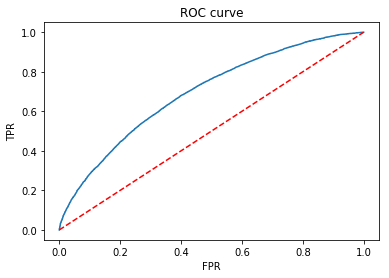

In [0]:
# ROC plot
fpr_xg, tpr_xg, _ = roc_curve(test.loc[:,test.columns == 'churn'], pred_xgb)

plt.clf()
plt.plot(fpr_xg, tpr_xg)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

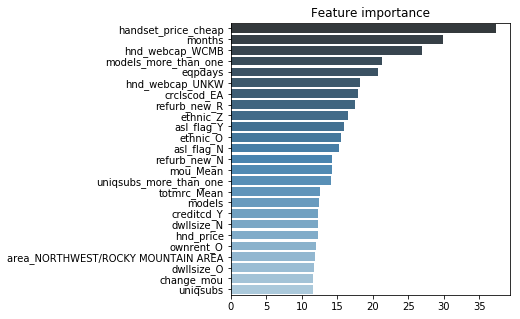

In [0]:
# Important Features
# xgb_model.get_score(importance_type='gain')
# xgb.plot_importance(xgb_model, max_num_features=20)

xg_ft_imp = pd.Series(data=xgb_model.get_score(importance_type='gain'), index=train.columns).sort_values(ascending=False)[:25]
plt.figure(figsize=(5,5))
plt.title("Feature importance")
ax = sns.barplot(y=xg_ft_imp.index, x=xg_ft_imp.values, palette="Blues_d", orient='h')